# Amazon Electronics Customer Segmentation

## Introduction

In this Notebook, we will be performing some Exploratory Data Analysis (EDA) on Amazon Electronic products metadata and reviews from 1996 to 2023. The data was scraped from Amazon and is large enough that Pandas cannot be used for data manipulation. Queries will be written using both Pyspark API and Spark SQL. In theory, the same types of queries can be written for either of them and they should have similar performance and run times. Using both methods enables verification that the same results can be obtained.

# Setup

In [1]:
from datasets import load_dataset
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, LongType, ArrayType, BooleanType
from pyspark import StorageLevel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
# Extract data from source
reviews = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_Electronics", trust_remote_code=True)
meta = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_meta_Electronics", split="full", trust_remote_code=True)
reviews = reviews["full"]

Loading dataset shards:   0%|          | 0/34 [00:00<?, ?it/s]

The data was obtained from https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023

In [3]:
print(type(reviews))
print(type(meta))
print(reviews.shape)
print(meta.shape)

<class 'datasets.arrow_dataset.Dataset'>
<class 'datasets.arrow_dataset.Dataset'>
(43886944, 10)
(1610012, 16)


```
import shutil
import os

# Save to Parquet (temporary folder)
reviews_path = "temp_reviews_parquet"
meta_path = "temp_meta_parquet"

reviews.to_parquet(reviews_path)
meta.to_parquet(meta_path)

# Create a SparkSession

In [4]:
# Rename to localhost
import os
os.environ["SPARK_LOCAL_HOSTNAME"] = "localhost"

In [5]:
# Create the SparkSession
spark = SparkSession.builder \
    .appName('amazon_electronics_data') \
    .config('spark.driver.memory', '16g') \
    .getOrCreate()
spark

In [6]:
# Display Memory setting
spark.sparkContext.getConf().get("spark.driver.memory")

'16g'

A SparkSession needs to be created before further work with PySpark can be done. Since the data is around 10 gb in size, Spark's default 1g of memory is insufficient and queries would not run. 16g is set and we verify that this is the case.

## Reviews Data

Parquet tables were created for the data for faster and more efficient manipulation of this large data. 

In [7]:
# Read the Parquet file
reviews = spark.read.parquet("data/temp_reviews_parquet")

# Create the Spark Table and Temp View for querying with Pyspark API and Spark SQL
reviews.createOrReplaceTempView('reviews')
reviews = spark.table('reviews')

The data is read successfully. A table and temporary view were created to run queries.

### Schema

In [8]:
# Print Reviews Schema
reviews.printSchema()

root
 |-- rating: double (nullable = true)
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- images: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- attachment_type: string (nullable = true)
 |    |    |-- large_image_url: string (nullable = true)
 |    |    |-- medium_image_url: string (nullable = true)
 |    |    |-- small_image_url: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- helpful_vote: long (nullable = true)
 |-- verified_purchase: boolean (nullable = true)



This data is on the user reviews of the products. A review consists of a title and a body of text. The asin and parent_asin represent product identifiers. Some products have some minor differences (likely in options like size or color).

### Show the First 10 Rows of the Data

In [9]:
spark.sql("""
SELECT *
FROM reviews
LIMIT 10
""").toPandas()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,3.0,Smells like gasoline! Going back!,First & most offensive: they reek of gasoline ...,"[(IMAGE, https://m.media-amazon.com/images/I/7...",B083NRGZMM,B083NRGZMM,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1658185117948,0,True
1,1.0,Didn’t work at all lenses loose/broken.,These didn’t work. Idk if they were damaged in...,[],B07N69T6TM,B07N69T6TM,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1592678549731,0,True
2,5.0,Excellent!,I love these. They even come with a carry case...,[],B01G8JO5F2,B01G8JO5F2,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1523093017534,0,True
3,5.0,Great laptop backpack!,I was searching for a sturdy backpack for scho...,[],B001OC5JKY,B001OC5JKY,AGGZ357AO26RQZVRLGU4D4N52DZQ,1290278495000,18,True
4,5.0,Best Headphones in the Fifties price range!,I've bought these headphones three times becau...,[],B013J7WUGC,B07CJYMRWM,AG2L7H23R5LLKDKLBEF2Q3L2MVDA,1676601581238,0,True
5,5.0,Great Fan! I’m a FAN!,"Light weight, quiet and totally awesome!!! It ...",[],B072DSHKCH,B07CML419K,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,1637522881041,0,True
6,5.0,solid sound for the price,Update 2-they sent a new warranty replacement....,[],B07BHHB5RH,B07BHHB5RH,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,1565130879386,0,True
7,5.0,Love the headphones - great range,These are fantastic headphones and I love that...,[],B07BND376H,B09S6Y5BRG,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,1541356831659,9,True
8,5.0,Five Stars,pretty good for the price.,[],B002HWRZ2K,B01LW71IBJ,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,1456772571000,0,True
9,5.0,BUY THIS THANG,yes.. so good. just buy it. my favorite featu...,[],B00WK47VEW,B017T99JPG,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,1456772365000,0,True


### Create a datetime column

We have a timestamp column using unix time using milliseconds. This is far less interpretable than something like datetime. Let's create a datetime column.

In [10]:
# Add the datetime column then update the table
reviews = spark.table("reviews").withColumn("datetime", F.from_unixtime(F.col("timestamp") / 1000))
reviews = reviews.drop('images')

# Update the view
reviews.createOrReplaceTempView("reviews")

```
# SQL timestamp conversion
spark.sql("""
SELECT date_format(timestamp_seconds(CAST(timestamp / 1000 AS BIGINT)), 'yyyy-MM-dd HH:mm:ss') AS datetime
FROM reviews
""")

Now we need to verify that the datetime column was added.

In [11]:
spark.sql("""
SELECT *
FROM reviews
LIMIT 10
""").toPandas()

,rating,title,text,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,datetime
0,3.0,Smells like gasoline! Going back!,First & most offensive: they reek of gasoline ...,B083NRGZMM,B083NRGZMM,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1658185117948,0,True,2022-07-18 15:58:37
1,1.0,Didn’t work at all lenses loose/broken.,These didn’t work. Idk if they were damaged in...,B07N69T6TM,B07N69T6TM,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1592678549731,0,True,2020-06-20 11:42:29
2,5.0,Excellent!,I love these. They even come with a carry case...,B01G8JO5F2,B01G8JO5F2,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1523093017534,0,True,2018-04-07 02:23:37
3,5.0,Great laptop backpack!,I was searching for a sturdy backpack for scho...,B001OC5JKY,B001OC5JKY,AGGZ357AO26RQZVRLGU4D4N52DZQ,1290278495000,18,True,2010-11-20 11:41:35
4,5.0,Best Headphones in the Fifties price range!,I've bought these headphones three times becau...,B013J7WUGC,B07CJYMRWM,AG2L7H23R5LLKDKLBEF2Q3L2MVDA,1676601581238,0,True,2023-02-16 19:39:41
5,5.0,Great Fan! I’m a FAN!,"Light weight, quiet and totally awesome!!! It ...",B072DSHKCH,B07CML419K,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,1637522881041,0,True,2021-11-21 12:28:01
6,5.0,solid sound for the price,Update 2-they sent a new warranty replacement....,B07BHHB5RH,B07BHHB5RH,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,1565130879386,0,True,2019-08-06 15:34:39
7,5.0,Love the headphones - great range,These are fantastic headphones and I love that...,B07BND376H,B09S6Y5BRG,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,1541356831659,9,True,2018-11-04 11:40:31
8,5.0,Five Stars,pretty good for the price.,B002HWRZ2K,B01LW71IBJ,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,1456772571000,0,True,2016-02-29 12:02:51
9,5.0,BUY THIS THANG,yes.. so good. just buy it. my favorite featu...,B00WK47VEW,B017T99JPG,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,1456772365000,0,True,2016-02-29 11:59:25


The datetime column was added.

### Summary Statistics

In [12]:
reviews\
.select('rating', 'helpful_vote')\
.summary('count', 'mean', 'stddev', 'min', '25%', '50%', '75%', 'max')\
.toPandas()

,summary,rating,helpful_vote
0,count,43886944,43886944
1,mean,4.099233772121385,1.0903363423983223
2,stddev,1.4123304685968932,22.575534823738767
3,min,0.0,-4
4,25%,4.0,0
5,50%,5.0,0
6,75%,5.0,0
7,max,5.0,46841


Here are the summary statistics for the numeric variables.  The areas of interest are the min rating of 0.0 and the min helpful_vote of -4. The ratings of 0.0 should be incorrect as Amazon ratings go from 1 to 5. Amazon used to have not helpful votes, but later took out that feature for their product user reviews. That -4 may be from that time.

### Null values

In [13]:
# Set the column names
cols = reviews.columns

# Generate SQL snippet for each column
null_checks = ",\n  ".join(
    [f"SUM(CASE WHEN {c} IS NULL THEN 1 ELSE 0 END) AS `{c}_nulls`" for c in cols]
)

# Create the query to check nulls
query = f"""
SELECT 
  {null_checks}
FROM reviews
"""

# Run the query
spark.sql(query).toPandas()

,rating_nulls,title_nulls,text_nulls,asin_nulls,parent_asin_nulls,user_id_nulls,timestamp_nulls,helpful_vote_nulls,verified_purchase_nulls,datetime_nulls
0,0,0,0,0,0,0,0,0,0,0


There are no null values in the reviews data.

### Number of unique values for each column

In [14]:
# Generate SQL snippet
uniques = ",\n  ".join(
    [f"COUNT(DISTINCT {c}) AS `{c}_unique`" for c in cols]
)

# Create the query
query = f"""
SELECT 
  {uniques}
FROM reviews
"""

# Run the query
spark.sql(query).toPandas()

,rating_unique,title_unique,text_unique,asin_unique,parent_asin_unique,user_id_unique,timestamp_unique,helpful_vote_unique,verified_purchase_unique,datetime_unique
0,6,19258533,38250600,1946161,1609860,18286191,42534478,2102,2,39949939


A couple of interesting/notable things here: 

We have 6 unique values for ratings which matches our previous finding of ratings being from 0.0 to 5.0. The only problematic value here is the 0.0. 

There are 38 million unique values for 'text,' which represents the bodies for reviews. Given that the data has around 43 million observations, around 5 million reviews have the same text. If we were to check the reviews, we may find that they are short and generally applicable such as 'Good.' 

The difference between 'asin' and 'parent_asin' is around 300,000. This value represents the number of products that appear to be the same but have different options like a shirt having different color options.

The number of unique verified purchases looks correct.

### Verified purchases for each rating

How many reviews (split between verified purchases) do we have for each rating?

In [15]:
spark.sql("""
SELECT 
    rating, 
    SUM(CASE WHEN verified_purchase = 'true' THEN 1 ELSE 0 END) AS `Number of Verified Purchases`,
    SUM(CASE WHEN verified_purchase = 'false' THEN 1 ELSE 0 END) AS `Number of Non-Verified Purchases`
FROM reviews
GROUP BY rating
ORDER BY rating DESC
""").toPandas()

,rating,Number of Verified Purchases,Number of Non-Verified Purchases
0,5.0,26044266,1785482
1,4.0,5044312,513413
2,3.0,2625915,257150
3,2.0,2028015,229589
4,1.0,4804374,554426
5,0.0,2,0


We previously saw that the min was 0.0 for ratings. Given that there are only 2 of them in the data, they are likely errors in data entry. We'll query and look at the 2 reviews in question. It is likely that the reviews had negative sentiment given the value is at the lower extreme for ratings. 

### Handling the reviews with ratings of 0

Let's query which rows have ratings of 0.

In [16]:
# Filter data for ratings of 0
spark.sql("""
SELECT rating, title, text, parent_asin, user_id
FROM reviews
WHERE rating = 0.0
""").toPandas()

,rating,title,text,parent_asin,user_id
0,0.0,NOT UNIVERSAL,Didn't work for my device.,B09Z6Q2MLC,AHCTFZB5JDOEM6GKBWF4PDEXMCPA
1,0.0,One Star,I need a replacement the unit was damaged an y...,B01F3ENAOU,AG5AKJ4EROK2F6BD4SCQVZ7WP7KQ


From the title and text, the reviews do indeed appear to have negative sentiment. Incidentally, the second one has a title of 'One Star.' Since the ratings were mistakenly entered as 0.0, let's correct them by setting them to 1.0.

Now that the ratings of 0 have been changed, let's make sure there are no longer any ratings of 0 in the data.

In [17]:
# Verify that there are no more ratings of 0
spark.sql("""
SELECT COUNT(rating)
FROM reviews
WHERE rating = 0.0
""").toPandas()

,count(rating)
0,2


We now have no reviews with ratings of 0.0 in the data. To check further, let's check the rows for those previous reviews, using the parent_asin and the user_id. 

In [18]:
# Check rows that previously had ratings of 0.0
spark.sql("""
SELECT rating, title, text, parent_asin, user_id
FROM reviews
WHERE parent_asin = 'B09Z6Q2MLC' AND user_id = 'AHCTFZB5JDOEM6GKBWF4PDEXMCPA'

UNION ALL

SELECT rating, title, text, parent_asin, user_id
FROM reviews
WHERE parent_asin = 'B01F3ENAOU' AND user_id = 'AG5AKJ4EROK2F6BD4SCQVZ7WP7KQ'
""").toPandas()

,rating,title,text,parent_asin,user_id
0,0.0,NOT UNIVERSAL,Didn't work for my device.,B09Z6Q2MLC,AHCTFZB5JDOEM6GKBWF4PDEXMCPA
1,0.0,One Star,I need a replacement the unit was damaged an y...,B01F3ENAOU,AG5AKJ4EROK2F6BD4SCQVZ7WP7KQ


The ratings have now been changed to 1 and the incorrect entries have been fixed.

### Handling negative helpful votes

Let's find all of the rows that have negative helpful votes.

In [19]:
spark.sql("""
SELECT *
FROM reviews
WHERE helpful_vote <0
ORDER BY datetime
""").show(truncate=14)

+------+--------------+--------------+----------+-----------+--------------+-------------+------------+-----------------+--------------+
|rating|         title|          text|      asin|parent_asin|       user_id|    timestamp|helpful_vote|verified_purchase|      datetime|
+------+--------------+--------------+----------+-----------+--------------+-------------+------------+-----------------+--------------+
|   5.0|Secure sour...|It's so hel...|B078162HNC| B078162HNC|AFGXFHGZ7NV...|1547336082365|          -1|             true|2019-01-12 ...|
|   5.0|Excellent R...|I have had ...|B082X3H6P9| B082X3H6P9|AEVZGLYSS3C...|1589208570253|          -4|             true|2020-05-11 ...|
|   5.0|Wow. Stunning.|Or, maybe i...|B08CVQ5SD9| B09M8DYH1B|AGCSSPVU3FJ...|1619730920197|          -2|             true|2021-04-29 ...|
|   5.0|   Very Handy!|Just what I...|B084GFMGN1| B0B2RK874T|AHFWJG5A5X2...|1625355873555|          -1|             true|2021-07-03 ...|
+------+--------------+--------------+---

Amazon used to have a 'not helpful vote' option, but that was later removed. There is no source that can be cited on the specific date, so we can't handle this in a targeted manner like leaving the values if the 'not helpful vote' option was there at that time. We will therefore change the negative values to 0. 

Next, we will remove those rows from the reviews data.

In [20]:
# Change those helpful votes to 0 and update the reviews table
reviews = reviews.withColumn(
    "helpful_vote",
    F.when(F.col("helpful_vote") < 0, 0).otherwise(F.col("helpful_vote"))
)

# Update the View for SparkSQL
reviews.createOrReplaceTempView("reviews")

Helpful Votes below 0 have been replaced and should now take values of 0. Next, we want to make sure that there are no longer any Helpful Votes below 0 in the data.

In [21]:
spark.sql("""
SELECT COUNT(helpful_vote)
FROM reviews
WHERE helpful_vote <0
""").toPandas()

,count(helpful_vote)
0,0


The handling went smoothly.

### Number of verified and non-verified purchases

How many verified and non-verified purchases do we have in the data?

In [22]:
spark.sql("""
SELECT 
SUM(CASE WHEN verified_purchase = 'true' THEN 1 ELSE 0 END) AS `Number of Verified Purchases`,
SUM(CASE WHEN verified_purchase = 'false' THEN 1 ELSE 0 END) AS `Number of Non-Verified Purchases`
FROM reviews
""").toPandas()

,Number of Verified Purchases,Number of Non-Verified Purchases
0,40546884,3340060


The number of non-verified purchases is around 10% that of the number of verified purchases.

### Which verified reviews were the most helpful?

Among product reviews, what's the highest numbers of helpful votes, rating, and product identifier (parent asin) for those reviews with verified purchases?

In [23]:
spark.sql("""
SELECT parent_asin, rating, title, text, verified_purchase, helpfuL_vote
FROM reviews
WHERE helpful_vote > 0 AND verified_purchase = 'true'
ORDER BY helpful_vote DESC
LIMIT 15
""").toPandas()

,parent_asin,rating,title,text,verified_purchase,helpfuL_vote
0,B010BWYDYA,5.0,Why and how the Kindle changes everything,"This is less a ""pros and cons"" review than a h...",True,46841
1,B075X8471B,5.0,What I once thought was silly is now a good th...,"Earlier this month, my TV entertainment includ...",True,32948
2,B00CX5P8FC,5.0,This box is a GAME CHANGER for on demand conte...,I am not a casual user of on-demand content an...,True,26331
3,B00154JDAI,1.0,BEWARE of the SIGNIFICANT DIFFERENCES between ...,I was DELIGHTED to upgrade my Kindle 1 to K2.....,True,24261
4,B07PHQ93TV,4.0,Not going to blow smoke...,I see so many people on here who are technolog...,True,18501
5,B01K8B8YA8,5.0,The Smartest of Them All!!! (Check out the vid...,[[VIDEOID:c05af0259c5236d5d0d0d5dea9bd875a]] H...,True,18147
6,B007OZNZQ0,5.0,Amazing new Kindle is nearly perfect except fo...,"So far, I love my new Paperwhite Kindle. I've ...",True,16478
7,B008GG93YE,4.0,New Kindle Buyer? Thinking about Nook? Read on...,I got my first Kindle. This is a nice ebook re...,True,15169
8,B09KQC7Z4S,5.0,I give it five stars. My wife hates them ...,I give it five stars. My wife hates them she w...,True,15074
9,B0BWD4WGJB,2.0,One major flaw.,"I bought this to use as a baby monitor, thinki...",True,14647


The most helpful product reviews with verified purchases tend to have high (4 or 5) ratings. Most of them are for different products. Those Helpful Vote counts above 18,000 are likely outliers.

### Which non-verified reviews were the most helpful?
Among product reviews, what's the highest numbers of helpful votes, rating, and product identifier (parent asin) for those reviews without verified purchases?

In [24]:
spark.sql("""
SELECT parent_asin, rating, title, text, verified_purchase, helpfuL_vote
FROM reviews
WHERE helpful_vote > 0 AND verified_purchase = 'false'
ORDER BY helpful_vote DESC
LIMIT 15
""").toPandas()

,parent_asin,rating,title,text,verified_purchase,helpfuL_vote
0,B000I1X6PM,3.0,Rift in the time-space continuum,"The minute I plugged this cable in, I knew som...",False,12587
1,B00LWHUBPO,5.0,Detailed Review of the Kindle,"As has been the case for years, Amazon sloooow...",False,10579
2,B08RLW7918,1.0,Spy alert!!!!!,"The camera video quality is definitely good, b...",False,9531
3,B000J36XR2,1.0,I have only a little time...,We live underground. We speak with our hands. ...,False,8957
4,B07ZPC9QD4,4.0,List of Features/Changes compared to Airpods (v2),"Like iphone 11 Pro, Macbook Pro, Airpad Pro; t...",False,8626
5,B08M8Y6473,3.0,"The Pros, Cons and Oks for Fitbit Versa 2 (HR).",Pros:__________<br />• It’s very comfortable. ...,False,8608
6,B009T3EYHO,4.0,A very good computer with a few drawbacks at a...,***Updates To My Review At The End***<br /><br...,False,8384
7,B07RJZPTLX,4.0,"The Pros, Cons and Oks for Kindle Oasis (HR).","Pros:__________<br />• It’s small, provides b...",False,7977
8,B00L403O8U,5.0,Financing Available!,I was able to purchase this amazing television...,False,7660
9,B0BVY4JVNG,1.0,Only half the equation. The other half will co...,I just received this today.<br /><br />I thoug...,False,7632


Reviews that aren't verified purchases tend to have much fewer helpful votes than those that do. The top 15 Helpful Vote count for the verified purchases are close to double the top 15 Helpful Vote count for the non-verified purchases, if we exclude potential outliers.

Some of the reviews also have formatting as part of the text. There is also one review that has a video, and we can see how it's handled in the data: converted to a video id.

### Verified purchases for each rating

How many verified and non-verified purchases do we have for each rating?

In [25]:
spark.sql("""
SELECT 
    rating, 
    SUM(CASE WHEN verified_purchase = 'true' THEN 1 ELSE 0 END) AS `Number of Verified Purchases`,
    SUM(CASE WHEN verified_purchase = 'false' THEN 1 ELSE 0 END) AS `Number of Non-Verified Purchases`
FROM reviews
GROUP BY rating
ORDER BY rating DESC
""").toPandas()

,rating,Number of Verified Purchases,Number of Non-Verified Purchases
0,5.0,26044266,1785482
1,4.0,5044312,513413
2,3.0,2625915,257150
3,2.0,2028015,229589
4,1.0,4804374,554426
5,0.0,2,0


Ratings between 2 to 4 have similar numbers if we were to account for the proportion of data. The number of non-verified purchases are around 10% the number of verified purchases for those ratings.

There tend to be more ratings of 5 for verified purchases and more ratings of 1 for non-verified purchases.

As expected, the ratings of 1 and 5 are where the difference lie. There may be more ratings from non-verified purchases due to review bombing from competitors.

### How many of each rating was there in year 2023?

In [26]:
spark.sql("""
SELECT 
    rating,
    COUNT(*) AS num_ratings_2023,
    SUM(CASE WHEN verified_purchase = 'true' THEN 1 ELSE 0 END) AS `Number of Verified Purchases`,
    SUM(CASE WHEN verified_purchase = 'false' THEN 1 ELSE 0 END) AS `Number of Non-Verified Purchases`
FROM reviews
WHERE YEAR(datetime) = 2023
GROUP BY rating
ORDER BY num_ratings_2023 DESC
""").toPandas()

,rating,num_ratings_2023,Number of Verified Purchases,Number of Non-Verified Purchases
0,5.0,1190958,1054998,135960
1,1.0,289692,268795,20897
2,4.0,198503,161945,36558
3,3.0,124327,109692,14635
4,2.0,105836,96773,9063


The number of 5.0 ratings is significantly higher than the numbers of other ratings. The second rating with the highest count is 1.0. It looks like reviewers on Amazon tend to gravitate to the extremes when rating Electronics products. The numbers could reflect how Amazon screens and removes fake reviews showing that their focus is on 1 star reviews instead of 5 star reviews. It could also mean that users are more likely to leave reviews on (Electronics) products that they are extremely pleased with.

## Meta Data

### Schema

In [27]:
# Read the Parquet file
meta = spark.read.parquet("data/temp_meta_parquet")

# Print Meta Schema
meta.printSchema()

root
 |-- main_category: string (nullable = true)
 |-- title: string (nullable = true)
 |-- average_rating: double (nullable = true)
 |-- rating_number: long (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- description: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- price: string (nullable = true)
 |-- images: struct (nullable = true)
 |    |-- hi_res: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- large: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- thumb: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- variant: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |-- videos: struct (nullable = true)
 |    |-- title: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- url: array (nullable = true)
 |    |    |-- element

This data represents product metadata. It contains information on the product, name, features, and seller. Subtitle and author are rather strange for Electronics products, so we'll look into that later.

In [28]:
# Create the Spark Table and Temp View for querying with Pyspark API and Spark SQL
meta.createOrReplaceTempView('meta')
meta = spark.table('meta')

### Show the First 10 Rows of the Data

In [29]:
spark.sql("""
SELECT *
FROM meta
LIMIT 10
""").toPandas()

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author
0,All Electronics,FS-1051 FATSHARK TELEPORTER V3 HEADSET,3.5,6,[],[Teleporter V3 The “Teleporter V3” kit sets a ...,None,"([None], [https://m.media-amazon.com/images/I/...","([], [], [])",Fat Shark,"[Electronics, Television & Video, Video Glasses]","{""Date First Available"": ""August 2, 2014"", ""Ma...",B00MCW7G9M,None,None,None
1,All Electronics,Ce-H22B12-S1 4Kx2K Hdmi 4Port,5.0,1,"[UPC: 662774021904, Weight: 0.600 lbs]",[HDMI In - HDMI Out],None,([https://m.media-amazon.com/images/I/51qxU4Zd...,"([], [], [])",SIIG,"[Electronics, Television & Video, Accessories,...","{""Product Dimensions"": ""0.83 x 4.17 x 2.05 inc...",B00YT6XQSE,None,None,None
2,Computers,Digi-Tatoo Decal Skin Compatible With MacBook ...,4.5,246,[WARNING: Please IDENTIFY MODEL NUMBER on the ...,[],19.99,([https://m.media-amazon.com/images/I/61RPxmi+...,"([AL 2Sides Video, MacBook Protective Skin, AR...",Digi-Tatoo,"[Electronics, Computers & Accessories, Laptop ...","{""Brand"": ""Digi-Tatoo"", ""Color"": ""Fresh Marble...",B07SM135LS,None,None,None
3,AMAZON FASHION,NotoCity Compatible with Vivoactive 4 band 22m...,4.5,233,[☛NotoCity 22mm band is designed for Vivoactiv...,[],9.99,([https://m.media-amazon.com/images/I/51ajKKbi...,"([], [], [])",NotoCity,"[Electronics, Wearable Technology, Clips, Arm ...","{""Date First Available"": ""May 29, 2020"", ""Manu...",B089CNGZCW,None,None,None
4,Cell Phones & Accessories,Motorola Droid X Essentials Combo Pack,3.8,64,"[New Droid X Essentials Combo Pack, Exclusive ...",[all Genuine High Quality Motorola Made Access...,14.99,"([None, None, None, None, None], [https://m.me...","([], [], [])",Verizon,"[Electronics, Computers & Accessories, Compute...","{""Product Dimensions"": ""11.6 x 6.9 x 3.1 inche...",B004E2Z88O,None,None,None
5,Sports & Outdoors,Raymarine Wi-Fish DownVision Blackbox Sonar wi...,3.5,25,[Black box Wi-Fi CHIRP DownVision sonar module...,[Transform your smartphone into a powerful CHI...,None,([https://m.media-amazon.com/images/I/719G-0+W...,"([], [], [])",Raymarine,"[Electronics, Car & Vehicle Electronics, Marin...","{""Item Package Dimensions L x W x H"": ""9.3 x 8...",B00TX536EK,None,None,None
6,Cell Phones & Accessories,"QGHXO Band for Garmin Vivofit 4, Soft Silicone...",4.4,707,[Personalized Your Garmin Vivofit 4 Activity T...,"[Compatibility, Custom designed for your preci...",14.89,([https://m.media-amazon.com/images/I/61J-V53D...,"([], [], [])",QGHXO,"[Electronics, Wearable Technology, Arm & Wrist...","{""Package Dimensions"": ""6.85 x 4.37 x 1.1 inch...",B07BJ7ZZL7,None,None,None
7,Industrial & Scientific,Protech iPhone 4 microscope 60X Lens with illu...,3.8,6,[iPhone 4 Microscope with White 2-LED and Dete...,[This accessory will convert your iPhone 4 int...,None,"([None, None, None, None, None, None, None, No...","([], [], [])",ProTech,"[Electronics, Camera & Photo, Binoculars & Sco...","{""Light Source Type"": ""LED"", ""Color"": ""Blue,Wh...",B005G99O2U,None,None,None
8,Computers,MOSISO Plastic Hard Shell Case & Keyboard Cove...,5.0,2,[],[],None,([https://m.media-amazon.com/images/I/71XrfOMK...,"([], [], [])",MOSISO,"[Electronics, Headphones, Earbuds & Accessorie...","{""Brand"": ""MOSISO"", ""Item Weight"": ""8 ounces"",...",B01MCZP7RF,None,None,None
9,None,"Fishfinder, Depth Finder Poly Sun Cover for 3""...",4.4,86,"[Made of poly material, Available in black, Dr...",[Affordable and convenient way to cover your s...,10.99,"([None, None, None, None], [https://m.media-am...","([Unboxing Gamin Vivid , Garmin Striker Vivid ...",Westlake Market,"[Electronics, Car & Vehicle Electronics, Marin...","{""Item Package Dimensions L x W x H"": ""7.32 x ...",B00R6R82HS,None,None,None


There's a lot of nulls for the last 3 columns. We should look into that later.

### Summary Statistics

In [30]:
meta\
.select('average_rating', 'rating_number', 'price')\
.summary('count', 'mean', 'stddev', 'min', '25%', '50%', '75%', 'max')\
.toPandas()

,summary,average_rating,rating_number,price
0,count,1610012,1610012,1610012
1,mean,4.0085408680183505,180.4833075778317,96.45767498849601
2,stddev,0.8331378499766278,2543.9800659979737,319.1737878683855
3,min,1.0,1,0.0
4,25%,3.6,3,11.99
5,50%,4.2,12,22.9
6,75%,4.6,49,59.99
7,max,5.0,1034896,—


There are 1,610,012 rows in the data.

The Average Rating column ranges in values from 1 to 5, which is reasonable. Unsurprisingly, Average Ratings of exactly 5 are extreme values that probably result from having very few reviews. Most of the Average Ratings are above 3 (around 4 according to the mean). The Rating Number has a '-'' for the max, which is likely due it being a string, as reported in the schema. The same thing goes for the price. Interestingly, most electronic products are below $60 in price.

In [31]:
# Define placeholder values that represent 'missing' data
placeholders = ['None', 'none', 'N/A', 'n/a', 'null', 'NULL', '']

# Convert placeholders to nulls
for c in meta.schema.fields:
    if isinstance(c.dataType, StringType):
        meta = meta.withColumn(
            c.name,
            F.when(F.col(c.name).isin(placeholders), None).otherwise(F.col(c.name))
        )

In [32]:
# Cast the price in the meta table
meta = meta.withColumn('price', F.expr("try_cast(price as double)"))

# Update the View for SparkSql 
meta.createOrReplaceTempView("meta")

In [33]:
meta\
.select('average_rating', 'rating_number', 'price')\
.summary('count', 'mean', 'stddev', 'min', '25%', '50%', '75%', 'max')\
.toPandas()

,summary,average_rating,rating_number,price
0,count,1610012,1610012,526449
1,mean,4.0085408680183505,180.4833075778317,96.45767498849601
2,stddev,0.8331378499766278,2543.9800659979737,319.1737878683855
3,min,1.0,1,0.0
4,25%,3.6,3,11.99
5,50%,4.2,12,22.9
6,75%,4.6,49,59.99
7,max,5.0,1034896,44630.0


We now have 44630.0 instead of '-' for the max price.

### Number of Nulls in the Data

In [34]:
# Set the column names
cols = meta.columns

# Generate SQL snippet for each column
null_checks = ",\n  ".join(
    [f"SUM(CASE WHEN {c} IS NULL THEN 1 ELSE 0 END) AS `{c}`" for c in cols]
)

# Create the query
query = f"""
SELECT 
  {null_checks}
FROM meta
"""

# Run the query
spark.sql(query).toPandas()

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author
0,106334,98,0,0,0,0,1083563,0,0,9570,0,0,0,1610012,1609161,1609536


The number of nulls look good for most of the data. The store having nulls might be related to third party sellers. For main_category though, we will need further investigation. There may a general main_category that aggregates other electronics that don't fit into any specific category. It looks like bought_together, subtitle, and author are entirely or mostly null. 

However, the price is extremely problematic. We have nulls for around 5/8 or 62.5% of the price column. 

In [35]:
# Use Common Table Expressions to store the Null and Not-Null queries, then join the CTEs
spark.sql("""
WITH null_counts AS (
  SELECT 
    SUM(CASE WHEN bought_together IS NULL THEN 1 ELSE 0 END) AS bought_together_nulls,
    SUM(CASE WHEN subtitle IS NULL THEN 1 ELSE 0 END) AS subtitle_nulls,
    SUM(CASE WHEN author IS NULL THEN 1 ELSE 0 END) AS author_nulls
  FROM meta
),
not_null_counts AS (
  SELECT 
    SUM(CASE WHEN bought_together IS NOT NULL THEN 1 ELSE 0 END) AS bought_together_not_nulls,
    SUM(CASE WHEN subtitle IS NOT NULL THEN 1 ELSE 0 END) AS subtitle_not_nulls,
    SUM(CASE WHEN author IS NOT NULL THEN 1 ELSE 0 END) AS author_not_nulls
  FROM meta
)

SELECT *
FROM null_counts
JOIN not_null_counts
""").toPandas()

,bought_together_nulls,subtitle_nulls,author_nulls,bought_together_not_nulls,subtitle_not_nulls,author_not_nulls
0,1610012,1609161,1609536,0,851,476


It looks like the table is mostly populated with null values for these columns. Bought_together in particular is entirely null and should be removed entirely.

### Checking Main Categories

In [36]:
spark.sql("""
SELECT DISTINCT main_category
FROM meta
""").toPandas()

,main_category
0,Audible Audiobooks
1,Premium Beauty
2,Computers
3,All Electronics
4,GPS & Navigation
5,Home Audio & Theater
6,Pet Supplies
7,Toys & Games
8,Baby
9,Sports & Outdoors


A lot of these categories don't belong here. We will remove them, but first let's explore other columns in the dataframe like the 'author' column. This column, and the two related columns, 'title' and 'subtitle,' should be related to the Books and Buy a Kindle categories. 

### Investigating Authors

Let's write a query to see what data we have where we have observations for the authors. 

In [37]:
spark.sql("""
SELECT main_category, title, subtitle, categories, author
FROM meta
WHERE author IS NOT NULL
LIMIT 5
""").toPandas()

,main_category,title,subtitle,categories,author
0,Books,Practical Modern Basketball (3rd Edition),3rd Edition,"[Electronics, Accessories & Supplies]",{'avatar': 'https://m.media-amazon.com/images/...
1,Books,Garmin GPSMAP 496 Qref Checklist (Qref Avionic...,"Spiral-bound – December 15, 2008","[Electronics, Car & Vehicle Electronics, Aviat...",{'avatar': 'https://m.media-amazon.com/images/...
2,Books,Sleepwalker: The Last Sandman,"Paperback – July 30, 2010","[Electronics, eBook Readers & Accessories, eBo...",{'avatar': 'https://m.media-amazon.com/images/...
3,Books,Disney Moana: Movie Theater Storybook & Movie ...,"Hardcover – October 4, 2016","[Electronics, Video Projectors]",{'avatar': 'https://m.media-amazon.com/images/...
4,Books,Estrella errante (Zodíaco) (Spanish Edition),"Paperback – October 1, 2017","[Electronics, Computers & Accessories, Compute...",{'avatar': 'https://m.media-amazon.com/images/...


It looks like there are actual books in the electronics product data. From the subtitles,these are physical books rather than eBooks from Kindle. Let's filter out the Books from the main_category and see what we get.

In [38]:
spark.sql("""
SELECT main_category, title, subtitle, categories, author
FROM meta
WHERE author IS NOT NULL AND main_category != 'Books'
LIMIT 5
""").toPandas()

,main_category,title,subtitle,categories,author
0,Buy a Kindle,Five Little Monkeys Storybook Treasury (A Five...,Kindle Edition,"[Electronics, Computers & Accessories, Compute...",{'avatar': 'https://m.media-amazon.com/images/...
1,Buy a Kindle,HF Antenna Accessories (Amateur Radio HF Anten...,Kindle Edition,"[Electronics, Television & Video, Accessories]",{'avatar': 'https://m.media-amazon.com/images/...
2,Buy a Kindle,An Orphan in the Snow: The heart-warming saga ...,Kindle Edition,"[Electronics, eBook Readers & Accessories, eBo...",{'avatar': 'https://m.media-amazon.com/images/...
3,Buy a Kindle,Sister Peters in Amsterdam,Kindle Edition,"[Electronics, Accessories & Supplies, Telephon...",{'avatar': 'https://m.media-amazon.com/images/...
4,Buy a Kindle,Basher Five-Two,Kindle Edition,"[Electronics, Car & Vehicle Electronics, Aviat...",{'avatar': 'https://m.media-amazon.com/images/...


Now we really have Kindle books. Let's further remove these with filters and see if there is any other data.

In [39]:
spark.sql("""
SELECT main_category, title, subtitle, author
FROM meta
WHERE author IS NOT NULL AND main_category != 'Books' AND main_category != 'Buy a Kindle'
""").toPandas()

,main_category,title,subtitle,author


So, the authors column has values only for products in the Books or Buy a Kindle main_categories. Let's remove them from the dataframe and see what happens to the 3 book related columns.

### Removing Books and Kindle eBooks

In [40]:
# Removing the targeted rows with Pyspark API
meta = meta\
.filter(
    ~F.col('main_category').isin('Books', 'Buy a Kindle') 
)

# Replace the view for SparkSql with the updated table
meta.createOrReplaceTempView("meta")

In [41]:
spark.sql("""
SELECT main_category, title, subtitle, author
FROM meta
WHERE author IS NOT NULL AND main_category != 'Books' AND main_category != 'Buy a Kindle'
""").toPandas()

,main_category,title,subtitle,author


The rows were removed as intended and the columns for author, title, and subtitle are now null, so these columns really had only values for products that were books and ebooks.

### Remove columns

Let's remove the bought_together, subtitle, and author columns since they are completely null. Let's remove the images and videos columns too.

In [42]:
# Remove the bought_together, subtitle, image, and videos columns
meta = meta.drop('bought_together', 'subtitle', 'author', 'images', 'videos')
meta.createOrReplaceTempView("meta")

### Remove all other incorrect categories

In [43]:
# List of unwanted categories
unwanted_categories = [
    'Pet Supplies',
    'Toys & Games',
    'Baby',
    'Grocery',
    'Collectible Coins',
    'Automotive',
    'Handmade',
    'Health & Personal Care',
    'Arts, Crafts & Sewing',
    'All Beauty',
    'AMAZON FASHION',
    'Premium Beauty',
    'Collectibles & Fine Art',
    'Magazine Subscriptions',
    'Digital Music',
    'Tools & Home Improvement',
    'Software',
    'Unique Finds',
    'Audible Audiobooks',
    'Gift Cards',
    'Sports & Outdoors',
    'Amazon Home',
]

# Removing the incorrect categories
meta = meta\
    .filter(
        ~F.col('main_category').isin(unwanted_categories) 
    )

# Replace the view for SparkSql with the updated table
meta.createOrReplaceTempView("meta")

### Highest Rated Products

In [44]:
spark.sql("""
SELECT 
parent_asin, title, rating_number, main_category
FROM meta
ORDER BY rating_number DESC
LIMIT 10
""").toPandas()

,parent_asin,title,rating_number,main_category
0,B07H65KP63,"Echo Dot (3rd Gen, 2018 release) - Smart speak...",1034896,Amazon Devices
1,B07GZFM1ZM,Fire TV Stick 4K streaming device with Alexa V...,819630,Amazon Devices
2,B07PXGQC1Q,Apple AirPods (2nd Generation) Wireless Earbud...,585624,Apple Products
3,B08F1P3BCC,Echo Dot (4th Gen) | Smart speaker with Alexa ...,584328,Amazon Devices
4,B07KTYJ769,"Amazon Smart Plug, for home automation, Works ...",542825,Amazon Devices
5,B0BGNG1294,"Amazon Basics HDMI Cable, 18Gbps High-Speed, 4...",507202,Home Audio & Theater
6,B0791TX5P5,Fire TV Stick streaming device with Alexa buil...,474536,Amazon Devices
7,B08CLNX58K,SanDisk 32GB 2-Pack Ultra MicroSDHC UHS-I Memo...,402800,Computers
8,B08WJSHSLC,Fire TV Stick (3rd Gen) with Alexa Voice Remot...,379565,Amazon Devices
9,B07HZLHPKP,"Echo Show 5 (1st Gen, 2019 release) -- Smart d...",356248,Amazon Devices


These are the products with the largest number of ratings. It does make sense that these products have a lot of ratings. The Echo Dot 3rd Gen has been discontinued, but an old page for it (https://a.co/d/eRzCkEj) shows around a million ratings and the numbers look legitimate. 

### Most Expensive Products

In [45]:
spark.sql("""
SELECT 
parent_asin, title, price, main_category
FROM meta
ORDER BY price DESC
LIMIT 10
""").toPandas()

,parent_asin,title,price,main_category
0,B01N1P1685,Panasonic PT DS20K2U - SXGA+ DLP Projector - 2...,30999.00,All Electronics
1,B08VWPYY6W,Intelligent Security Patrol Service Robot Auto...,26888.00,Industrial & Scientific
2,B0B3S78JFL,LG 97-Inch Class OLED evo Gallery Edition G2 S...,24996.99,All Electronics
3,B01NBNX2NP,Sony VPLVZ1000ES Ultra-Short Throw 4K HDR Home...,24995.00,All Electronics
4,B074Z53X99,Sony VPLVW885ES 4K HDR Laser Home Theater Vide...,23390.12,All Electronics
5,B07TS6J1DN,Wacom Intuos Small Refurbished Graphics Drawin...,21111.35,Computers
6,B01GGNKUS6,Panasonic 4K UHD 2160P LED-Backlit LCD Flat Pa...,19974.00,Computers
7,B07GM3J6SH,Sony 4K HDR Laser Home Theater Video Projector...,19458.93,All Electronics
8,B07HY8HTKR,JVC DLA-NX9 4K Home Theater Projector with 8K/...,17999.99,All Electronics
9,B00WF9GZV2,HP 5412R 92GT PoE+/4SFP+ (No PSU) v3 zl2 Switc...,17937.16,Computers


The priciest electronics products are mainly projectors. Other items include massive tvs, a high-end tablet for artists, and a network switch from HP.

### Cheapest Products

In [46]:
spark.sql("""
SELECT 
parent_asin, title, price, main_category
FROM meta
ORDER BY price
LIMIT 10
""").toPandas()

,parent_asin,title,price,main_category
0,B07RRB4LMP,Sykiila for Older MacBook Air 13 Inch Case for...,NaN,Computers
1,B06X158J4Y,"Double Cab Dual 12"" Sealed Subwoofer Sub Box E...",NaN,Car Electronics
2,B010PAUNTM,Eathtek Replacement CPU Cooling Cooler Fan for...,NaN,Industrial & Scientific
3,B004U537RE,"Impact Sync Cord - 1/4"" Phono Male to PC Male ...",NaN,Camera & Photo
4,B006Z8PM3G,2 Way DB9 Male AB Data Manual Share Switch Box...,NaN,Computers
5,B018U2KU7W,Senders 10pcs 2GB USB 2.0 Flash Drive Memory S...,NaN,Computers
6,B07Q1NWY4L,EK Water Blocks EK-Vector RTX RE Ti - Copper +...,NaN,Industrial & Scientific
7,B0013EVFSI,Induro Tripod Head SA-01,NaN,Camera & Photo
8,B00BFNHRKM,Lexar JumpDrive S70 8GB USB Flash Drive LJDS70...,NaN,Computers
9,B07CVS7K88,"USB C Hub, Type C Adapter 8-in-1 Multiport Des...",NaN,Cell Phones & Accessories


We've got a lot of null prices. There doesn't seem to be a good way to handle them other than to ignore their prices or remove them entirely. Imputing prices would have to be done for each product individually, which someone with a data entry role could be assigned to do. Let's query again, but this time remove the nulls from consideration.

In [47]:
spark.sql("""
SELECT 
parent_asin, title, price, main_category
FROM meta
WHERE price IS NOT NULL
ORDER BY price
LIMIT 10
""").toPandas()

,parent_asin,title,price,main_category
0,B0B37MK4PB,Power Supply Tester Checker 20/24 Pin for PSU ...,0.01,Industrial & Scientific
1,B00005AR4H,Handspring Visor Edge Hard Case (Metallic Silver),0.01,All Electronics
2,B09C3CGRJK,[3 Pack] Slide Webcam Cover Ultra Slim Web Cam...,0.01,Cell Phones & Accessories
3,B004MF0Z2C,Griffin Screen Care Kit 5 pack for Archos 7 GB...,0.01,Computers
4,B000AYKV00,10Ft usb 2.0 A (Male) to A (Male) cable,0.01,Computers
5,B082MMJB5Q,hudiemm0B Thermal Grease Paste Compound Silico...,0.01,Computers
6,B0BZCPSL51,"Bone Conduction Headphones, Open Ear Sports Wi...",0.01,All Electronics
7,B082ZKK4GR,Cute Crystal Clear Transparent Cover Case Comp...,0.01,Cell Phones & Accessories
8,B091265SJZ,LUYANhapy9 Wired Headset Universal 3.5mm in-Ea...,0.01,All Electronics
9,B005YR0C48,Faces Case for iPod Touch 4G Blue,0.01,Cell Phones & Accessories


The prices for these products look incorrect. Of course, it is possible that these prices are genuine, but they likely don't take into account something like shipping costs. I've seen something like this when I was viewing on Amazon or Ebay before. The seller deliberately put low prices, but charged 10s or 100s of dollars for the shipping.

### List Main Categories by Count and Show the Top 20

In [48]:
spark.sql("""
SELECT DISTINCT 
    main_category, 
    COUNT(parent_asin) AS cat_count
FROM meta
GROUP BY main_category
ORDER BY cat_count DESC
LIMIT 20
""").toPandas()

,main_category,cat_count
0,Computers,418868
1,All Electronics,376435
2,Camera & Photo,223690
3,Cell Phones & Accessories,138237
4,Home Audio & Theater,106516
5,Industrial & Scientific,50555
6,Car Electronics,27332
7,Office Products,21250
8,GPS & Navigation,9339
9,Amazon Devices,8484


The categories look mostly reasonable. It's hard to imagine what electronics products there are for Amazon Fashion though. Computers, cameras, cell phones, and home audio & theatre are the most common products listed on Amazon.

### Best Rated Products

In [49]:
spark.sql("""
SELECT 
    title,
    parent_asin,
    average_rating,
    rating_number,
    main_category
FROM meta
ORDER BY average_rating DESC
LIMIT 10
""").toPandas()

,title,parent_asin,average_rating,rating_number,main_category
0,"Dell 2023 Inspiron 16 7620 2-in-1 16"" Touchscr...",B08SJJG6ZX,5.0,2,Computers
1,HP - 2UX37AA#ABB - Universal World Travel Adap...,B079QFMZWD,5.0,3,Industrial & Scientific
2,"in-Ear Headphones,Stylish Earbuds Bluetooth Ea...",B0915WLZ59,5.0,1,All Electronics
3,"Lenovo 2023 IdeaCentre AIO 5 24 23.8"" Touchscr...",B0C6XWN7NW,5.0,2,Computers
4,HP 14 2020 Newest Business Laptop Computer I 1...,B08B41M4WS,5.0,1,Computers
5,"AEXGE 8"" Universal Carrying Case Slim Fit Foli...",B00LC1T42G,5.0,1,Computers
6,CYMBAINK Remanufactured Toner Cartridge Replac...,B08YD5V5CD,5.0,1,All Electronics
7,HQRP AC Adapter/Power Supply Compatible with F...,B004JUNG8A,5.0,4,Camera & Photo
8,"Godox AK-R14 Four-Wing Reflector,Compatible fo...",B07VGFHBQT,5.0,1,Camera & Photo
9,Dell OptiPlex 9020 Business Premium Desktop PC...,B096G5YSYX,5.0,1,Computers


Unsurprisingly, the products with the highest average ratings (at the maximum value of 5) have very few ratings. Something similar will probably appear for those with the lowest ratings.

### What are the most popular products?

In [50]:
spark.sql("""
SELECT 
    title,
    parent_asin,
    average_rating,
    rating_number,
    main_category
FROM meta
ORDER BY rating_number DESC
LIMIT 10
""").toPandas()

,title,parent_asin,average_rating,rating_number,main_category
0,"Echo Dot (3rd Gen, 2018 release) - Smart speak...",B07H65KP63,4.7,1034896,Amazon Devices
1,Fire TV Stick 4K streaming device with Alexa V...,B07GZFM1ZM,4.7,819630,Amazon Devices
2,Apple AirPods (2nd Generation) Wireless Earbud...,B07PXGQC1Q,4.7,585624,Apple Products
3,Echo Dot (4th Gen) | Smart speaker with Alexa ...,B08F1P3BCC,4.7,584328,Amazon Devices
4,"Amazon Smart Plug, for home automation, Works ...",B07KTYJ769,4.7,542825,Amazon Devices
5,"Amazon Basics HDMI Cable, 18Gbps High-Speed, 4...",B0BGNG1294,4.7,507202,Home Audio & Theater
6,Fire TV Stick streaming device with Alexa buil...,B0791TX5P5,4.7,474536,Amazon Devices
7,SanDisk 32GB 2-Pack Ultra MicroSDHC UHS-I Memo...,B08CLNX58K,4.7,402800,Computers
8,Fire TV Stick (3rd Gen) with Alexa Voice Remot...,B08WJSHSLC,4.7,379565,Amazon Devices
9,"Echo Show 5 (1st Gen, 2019 release) -- Smart d...",B07HZLHPKP,4.6,356248,Amazon Devices


In this project, product popularity is approximated using the number of user reviews. While this is not a direct measure of sales or market share, it serves as a practical proxy, assuming that more popular products tend to receive more reviews.

The products with the most ratings also tend to have very high average ratings. 

Amazon devices, such as Echo Dots and Fire Sticks, are extremely popular.

### Most Popular Products Excluding Amazon Devices

In [51]:
spark.sql("""
SELECT 
    title,
    parent_asin,
    average_rating,
    rating_number,
    main_category
FROM meta
WHERE main_category != 'Amazon Devices'
ORDER BY rating_number DESC
LIMIT 10
""").toPandas()

,title,parent_asin,average_rating,rating_number,main_category
0,Apple AirPods (2nd Generation) Wireless Earbud...,B07PXGQC1Q,4.7,585624,Apple Products
1,"Amazon Basics HDMI Cable, 18Gbps High-Speed, 4...",B0BGNG1294,4.7,507202,Home Audio & Theater
2,SanDisk 32GB 2-Pack Ultra MicroSDHC UHS-I Memo...,B08CLNX58K,4.7,402800,Computers
3,TOZO T10 Bluetooth 5.3 Wireless Earbuds with W...,B08XPWDSWW,4.3,349254,Home Audio & Theater
4,SanDisk 256GB Extreme microSDXC UHS-I Memory C...,B09V1FT19S,4.8,337225,Computers
5,Apple AirPods Pro,B07ZPC9QD4,4.8,300544,Apple Products
6,SanDisk Cruzer Blade 16GB USB 2.0 Flash Drive,B0BSFT117F,4.7,260446,All Electronics
7,TOZO T6 True Wireless Earbuds Bluetooth 5.3 He...,B08XNCHTCY,4.4,249207,All Electronics
8,SanDisk 32GB Ultra MicroSDHC UHS-I Memory Card...,B00EKPHOY6,4.7,234767,Computers
9,SanDisk 32GB Ultra MicroSDHC UHS-I Memory Card...,B073JWXGNT,4.7,233718,Computers


There is still an Amazon Product in this table, so let's exclude also the items with 'Amazon' in their titles. Also, there are some products with the same title, although they may have different parent_asin identifiers. Let's restrict to unique values as well. 

In [52]:
spark.sql("""
SELECT DISTINCT
    title,
    max(parent_asin) AS parent_asin,
    max(average_rating) AS average_rating,
    max(rating_number) AS rating_number,
    main_category
FROM meta
WHERE main_category != 'Amazon Devices' AND title NOT LIKE 'Amazon%'
GROUP BY title, main_category
ORDER BY rating_number DESC
""").toPandas()

,title,parent_asin,average_rating,rating_number,main_category
0,Apple AirPods (2nd Generation) Wireless Earbud...,B07PXGQC1Q,4.7,585624,Apple Products
1,SanDisk 32GB 2-Pack Ultra MicroSDHC UHS-I Memo...,B08CLNX58K,4.7,402800,Computers
2,TOZO T10 Bluetooth 5.3 Wireless Earbuds with W...,B08XPWDSWW,4.3,349254,Home Audio & Theater
3,SanDisk 256GB Extreme microSDXC UHS-I Memory C...,B09V1FT19S,4.8,337225,Computers
4,Apple AirPods Pro,B07ZPC9QD4,4.8,300544,Apple Products
...,...,...,...,...,...
1348030,"winemana Universal Portable Laptop Stand, Swiv...",B07R52SBDX,2.0,1,Office Products
1348031,"zumo 660LM 4.3"""" Touchscreen With Electronic C...",B015VELV16,5.0,1,All Electronics
1348032,【2 Way Audio】 All in One with 16inch Monitor 3...,B08XX8BHZ6,5.0,1,Camera & Photo
1348033,"【Newest Earphone in 2019】Bracelet Earphone,201...",B07VYG8ZYD,5.0,1,All Electronics


The most popular products seem to be Computer products and Apple products. 

The most popular Apple products are acessories, and among the Apple products, audio devices like the AirPods are the most popular.

Of the Computer Products, memory cards and hard drives are the most popular.

### Store Info (Seller with most reviews)

## Join Tables

In [53]:
# Left Join and create a view with Spark SQL 
spark.sql("""
CREATE OR REPLACE TEMP VIEW joined_view AS
SELECT 
    r.*, 
    m.main_category, 
    m.title AS product_name,
    m.price,
    m.average_rating AS avg_product_rating,
    m.categories,
    m.description,
    m.details
FROM reviews r
LEFT JOIN meta m
USING(parent_asin)
""")

# Query the first 10 rows of the joined_view table with SparkSQL
spark.sql("""
SELECT *
FROM joined_view
LIMIT 10
""").toPandas()

,parent_asin,rating,title,text,asin,user_id,timestamp,helpful_vote,verified_purchase,datetime,main_category,product_name,price,avg_product_rating,categories,description,details
0,B00068E91M,5.0,Nice!,I was putting a system in my RV for dry campin...,B00068E91M,AHOZS6XHLIVIGVYZXMGF2FVDPIYQ,1224633285000,8,True,2008-10-21 16:54:45,Car Electronics,Cobra CPI-A20 Power Inverter Remote Control Wa...,41.44,4.3,"[Electronics, Portable Audio & Video, Portable...",[Cobra's HighGear external speakers are design...,"{""Item Weight"": ""198.44 Grams"", ""Product Dimen..."
1,B000VCLCHW,4.0,Has flows,I have been using this laptop extensively sinc...,B000VCLCHW,AEH6UNODLEICR272E4Y7P34DFIJQ,1402677071000,0,False,2014-06-13 09:31:11,Computers,Sony VAIO VGN-CR220E/R 14.1-inch Laptop (Intel...,NaN,3.7,"[Electronics, Computers & Accessories, Compute...","[Product description, The Sony VGN-CR220E/R 14...","{""Standing screen display size"": ""14.1 Inches""..."
2,B0015A8Q7S,5.0,Fair price and good product,Fit perfect on my new after market speakers an...,B0015A8Q7S,AFYE72D7325R7KC7BRKLITBRZXQQ,1619277840388,0,True,2021-04-24 08:24:00,Car Electronics,Scosche Compatible with Select 2005 to 2020 Bu...,13.99,4.5,"[Car & Vehicle Electronics, Vehicle Electronic...",[The Scosche SAGMHR634B speaker adapter pair i...,"{""Item Weight"": ""4.2 ounces"", ""Product Dimensi..."
3,B003S9XLW4,5.0,Rangers Skin,This skin is a nice way to make my inner fan h...,B003S9XLW4,AEY6ZB7OWPFLRFFC3PWLIDJSON2Q,1380835228000,0,True,2013-10-03 14:20:28,Cell Phones & Accessories,Skinit New York Rangers Solid Background Vinyl...,NaN,5.0,"[Electronics, Portable Audio & Video, MP3 & MP...",[Skinit allow you to personalize and protect y...,"{""Product Dimensions"": ""10.5 x 7.5 x 0.1 inche..."
4,B007CZDS64,5.0,This RAM,"This ram screams. It might be pricy, but you'r...",B007CZDS64,AGRZIDRSYAWLM3IX6SGXLXEF5HAA,1387374162000,3,True,2013-12-18 06:42:42,Computers,G.SKILL RipjawsX Series 16GB (2 x 8GB) 240-Pin...,NaN,4.0,"[Electronics, Computers & Accessories, Compute...","[Model, Brand:, G.SKILL, Series:, Ripjaws X Se...","{""RAM"": ""8 GB DDR3"", ""Memory Speed"": ""2133 MHz..."
5,B009NI8JRG,2.0,"NOT for a 13"" MacBook Pro","I says it's for MacBook Pro 13&#34;, but it wa...",B009NI8JRG,AGCL4RC2X2ARB3JKUHJL5FPYVRJQ,1505818401793,0,True,2017-09-19 03:53:21,Computers,"Incase Pathway Folio for 13"" MacBook Pro / Air...",9.99,2.8,"[Electronics, Computers & Accessories, Laptop ...",[],"{""Brand"": ""Incase Designs"", ""Compatible Device..."
6,B00BWF5U0M,2.0,Don’t waste your money or time,"Neither my speakers, camera or printer worked ...",B00BWF5U0M,AFX452CTO2RP2OIVB4NYO46HSIGQ,1602123632889,0,True,2020-10-07 19:20:32,Computers,SABRENT 4 Port USB 2.0 Data Hub with Individua...,8.99,4.6,"[Electronics, Computers & Accessories, Network...",[],"{""Wireless Type"": ""802.11bgn"", ""Number of USB ..."
7,B00BWF5U0M,5.0,Fantastic little Device,Running a laptop on a small solar power systme...,B00BWF5U0M,AF7N32BM7TEJ6R7VWBF2GHIWLMZQ,1376428883000,6,True,2013-08-13 14:21:23,Computers,SABRENT 4 Port USB 2.0 Data Hub with Individua...,8.99,4.6,"[Electronics, Computers & Accessories, Network...",[],"{""Wireless Type"": ""802.11bgn"", ""Number of USB ..."
8,B00C1VEDJU,4.0,Four Stars,Was as advertised,B00C1VEDJU,AF7UNSE6Y4R6FABAPSPPBZ7YYX4A,1435787974000,0,True,2015-07-01 14:59:34,Computers,Case-online For Apple iPad 2/3/4 Luxury Pu Lea...,NaN,4.2,"[Electronics, Computers & Accessories, Tablet ...",[Case-online For Apple iPad 2/3/4 Luxury Pu Le...,"{""Product Dimensions"": ""9.8 x 7.8 x 0.9 inches..."
9,B00DZT96C6,4.0,Two factors keep me from giving it five stars:...,Two factors keep me from giving it five stars:...,B00DZT96C6,AHDRQJGGNBGUMLGOGLP25ZMTMAHQ,1462447395000,0,True,2016-05-05 04:23:15,Computers,Acer G206HQL bd 19.5-Inch LED Computer Monitor...,NaN,4.4,"[Electronics, Computers & Accessories, Monitors]",[Acer G206HQL monitor sports a super-slim prof...,"{""Standing screen display size"": ""19.5 Inch

In [54]:
joined_table = spark.table('joined_view')

### 2023 Rating Distribution by Verified Purchase

In [55]:
# Store the query for rating distribution in 2023
verified_purchase_dist_2023 = joined_table\
                                .filter(F.year("datetime") == 2023) \
                                .groupBy("rating") \
                                .agg(
                                    F.sum(F.when(F.col("verified_purchase") == "true", 1).otherwise(0)).alias("Number of Verified Purchases"),
                                    F.sum(F.when(F.col("verified_purchase") == "false", 1).otherwise(0)).alias("Number of Non-Verified Purchases")
                                )\
                                .orderBy('rating', ascending=False)
# Convert to Pandas for plotting
verified_purchase_dist_2023 = verified_purchase_dist_2023.toPandas()

# Melt into long form for seaborn:
vp_dist_2023_melt = verified_purchase_dist_2023.melt(
    id_vars='rating',
    value_vars=['Number of Verified Purchases', 'Number of Non-Verified Purchases'],
    var_name='Purchase Type',
    value_name='Count'
)

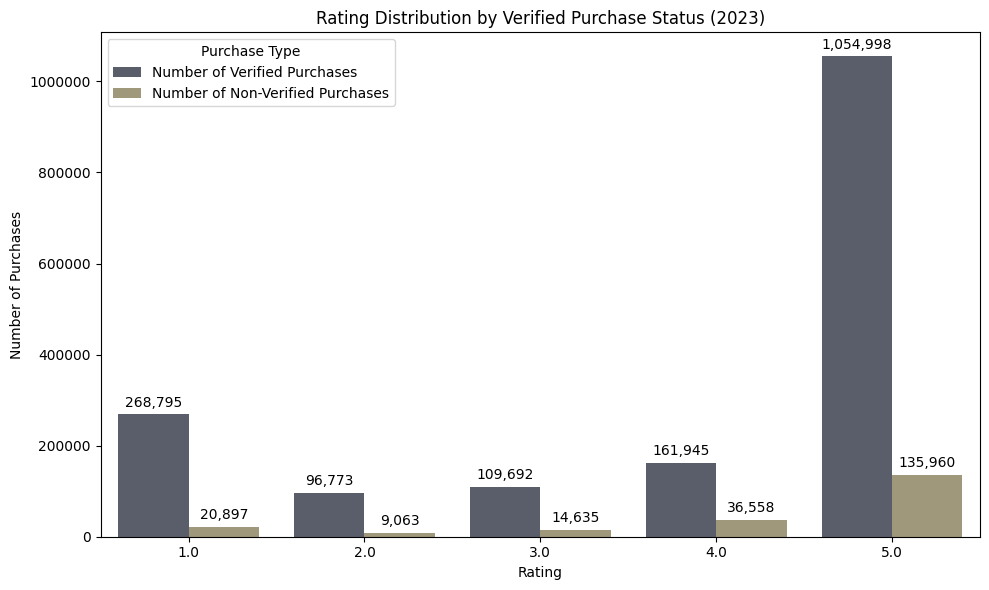

In [60]:
# Plot the grouped bar chart
plt.figure(figsize=(10, 6))
plt.ticklabel_format(style='plain', axis='y') # Disable scientific notation

ax = sns.barplot(
    data=vp_dist_2023_melt,
    x='rating',
    y='Count',
    hue='Purchase Type',
    palette='cividis'
)

# Add value labels on top of each bar
for bar in ax.patches:
    height = bar.get_height()
    if height > 0:
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + max(vp_dist_2023_melt['Count']) * 0.01,
            f'{int(height):,}',
            ha='center',
            va='bottom',
        )

# Chart formatting
plt.title('Rating Distribution by Verified Purchase Status (2023)')
plt.xlabel('Rating')
plt.ylabel('Number of Purchases')
plt.tight_layout()
plt.savefig('rating_distribution')
plt.show()

### 2023 Most Reviewed Products

In [58]:
# Store the query
product_popularity = joined_table\
    .filter(
        (F.year('datetime') == 2023) &
        (F.col('verified_purchase') == 'true')
    )\
    .groupBy(
        'parent_asin',
        'product_name',
        F.year('datetime').alias('year'),
        'avg_product_rating'
    )\
    .agg(F.count('*').alias('Review Counts'))\
    .orderBy(F.col('Review Counts').desc())\
    .limit(20)\

# Convert to Pandas DataFrame
product_popularity = product_popularity.toPandas()

# Truncate long product names
product_popularity['product_name'] = product_popularity['product_name'].apply(lambda x: x[:37] + '...' if x is not None and len(x) > 40 else x)

# Sort by review count
product_popularity = product_popularity.sort_values('Review Counts', ascending=False)

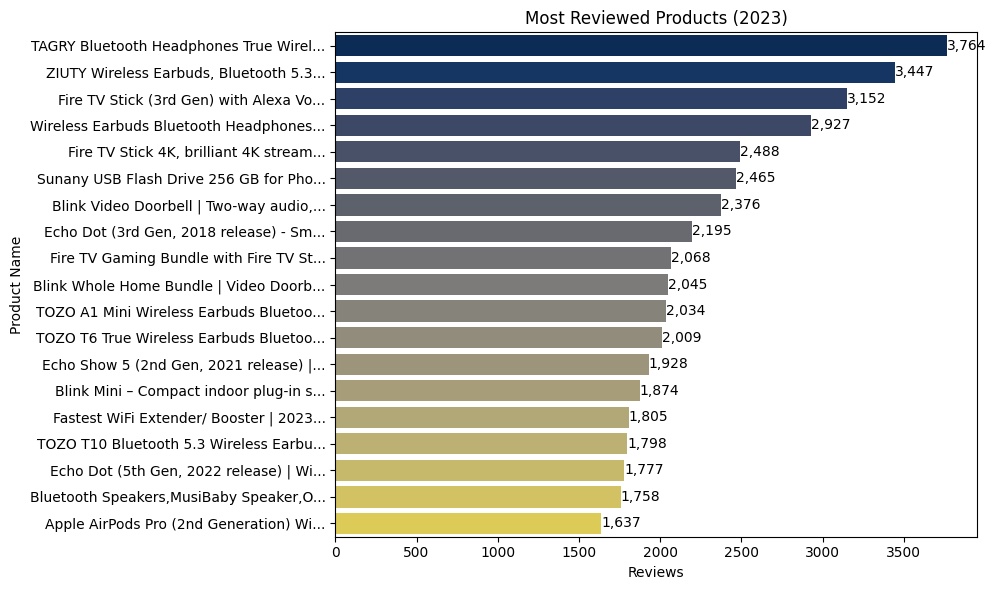

In [61]:
# Set plot style
plt.figure(figsize=(10, 6))

# Create the barplot
ax = sns.barplot(
    x='Review Counts',
    y='product_name',
    hue='product_name',
    data=product_popularity,
    palette='cividis',
    legend=False
)

# Add labels on bars
for i in ax.patches:
    width = i.get_width()
    ax.text(
        width,
        i.get_y() + i.get_height() / 2,
        f'{int(width):,}',
        va='center'
    )

# Set labels and title
plt.xlabel('Reviews')
plt.ylabel('Product Name')
plt.title('Most Reviewed Products (2023)')
plt.tight_layout()
plt.savefig('2023_popular_products')
plt.show()

In this project, product popularity is approximated using the number of user reviews. While this is not a direct measure of sales or market share, it serves as a practical proxy, assuming that more popular products tend to receive more reviews.

Looking at the product names, small electronic devices were the most popular in 2023. Wireless audio devices (earbuds/headphones) were by far the most popular. Aside from wireless audio devices, other popular electronics in 2023 were flash drives and various home improvement products such as cameras and Echo Dots.

# Close the SparkSession

In [62]:
# Stop the SparkSession
spark.stop()

# Conclusion

As the data was scraped, there may be some issues with the process such as how books were included in the data.

Memory cards and bluetooth audio devices are have large number of reviews, and we could say they are extremely popular by proxy. Amazon could try to tap into the demand for these items by developing their own Amazon Basics versions of these. 

If Amazon already has their own brand of such products, an investigation into why they aren't selling as well as products by other brands should be conducted. For example, how does sound quality and connectivity compare with other brands? Or how do read and write speeds compare to memory cards from other brands?

Echo Dots and Fire TV Sticks are still popular and should continue to be developed. 

